# Generative Adversarial Networks: the Basics

### <u>This notebook is the Pytorch replicate of the [Tensorflow notebook](https://github.com/stfc-ai4s/sciml-workshop-tf/blob/main/course_3.0_with_solutions/GAN/GAN_practical.ipynb) from the sciml-workshop-tf course.</u>

Generative Adversarial Networks (GANs) represents one of the most exciting recent innovation in deep learning. GANs were originally introduced by Ian Goodfellow and Yoshua Bengio from the University of Montreal, in 2014 and Yann LeCun considered them as ‘the most interesting idea in the last 10 years in ML’ .

A GAN is a generative model in which two neural networks are competing in a typical game theory scenario. The first neural network is the generator, responsible of generating new synthetic data instances that resemble your training data, while its adversary, the discriminator tries to distinguish between real (training) and fake (artificially generated) samples generated by the generator. The mission of the generator is to try fooling the discriminator, and the discriminator tries to resist from being fooled. That’s why the system as a whole is described as adversarial. ([Source](https://towardsdatascience.com/generative-adversarial-networks-gans-2231c5943b11))


<img src="https://miro.medium.com/max/2000/1*XKanAdkjQbg1eDDMF2-4ow.png" alt="gan.png" style="width: 700px;"/>

<img src="https://miro.medium.com/max/1400/1*FbQLpEVQKsMSK-c7_5KcWw.png" alt="gan.png" style="width: 700px;"/>

([Source](https://towardsdatascience.com/generative-adversarial-networks-explained-34472718707a))




* Further reading:

    💡 [ThisXDoesNotExist.com](https://thisxdoesnotexist.com/) displays realistic and diverse contents generated by GANs.

    💡 [NIPS 2016 Tutorial:Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf).


In this notebook, we will train a GAN to generate handwritten digits based on the `mnist-digits` dataset.  

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam

import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary

# check version
print('Using Pytorch v%s' % torch.__version__)

# helpers
import numpy as np
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

Using Pytorch v2.3.0


In [2]:

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"device: {device}")


device: cuda


In [3]:
# Set random seed for reproducibility
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [4]:
# Batch size during training
batch_size = 256

# Batch size for sampling images (for vizualisation)
viz_batch_size = 64

# # Spatial size of training images.
image_size = (28,28)

# Number of channels in the training images. For color images this is 3
num_channels = 1

# Size of z latent vector (i.e. size of generator input)
d_z = 100

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 1e-4

---

# The Dataset

We start by loading the `mnist` dataset.

In [5]:
train_dataloader = DataLoader(
    datasets.MNIST(
        "../../workshop_data/sciml-workshop/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(image_size[0]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# print info about data
print("Number of training data: %d" % len(train_dataloader.dataset))
print("Image pixels (image size): %s" % str(train_dataloader.dataset[0][0][0].shape))

class_info = train_dataloader.dataset.classes
n_classes = len(class_info)
print(f"MNIST's {n_classes} target classes: {class_info}")


Number of training data: 60000
Image pixels (image size): torch.Size([28, 28])
MNIST's 10 target classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


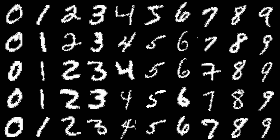

In [6]:
max_imgs_per_class = 5
examples = {i: [] for i in range(n_classes)}

for x, i in train_dataloader.dataset:
    if all([len(ex) == max_imgs_per_class for ex in examples.values()]):
        break
    if len(examples[i]) < max_imgs_per_class:
        examples[i].append(x)
          

grid = torch.cat([torch.cat(examples[i], dim=1) for i in range(n_classes)], dim=2)
transforms.ToPILImage()(grid)

---

# Create a GAN

## Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with `mean=0`, `stdev=0.02`. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [7]:
# custom weights initialization called on ``generator`` and ``discriminator``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### The generator

First, we create the generator network. The generator generates an image by upsampling a **seed** (a random noise vector) several times. Each upsampling is conducted by a `ConvTranspose2d` layer. We start with a `Linear` layer that upscales the seed into a proper size such that it can be reshaped into a stack of small images; next, several `Conv2d` and `ConvTranspose2d` layers are followed to process and upsample the small images into the original image size. All layers use `ReLU` for activation except the output layer, which uses `Tanh` (note that we have normalised the pixel values to [-1, 1] in the previous section).

**Takeaway**: the generator transforms a seed (a random noise vector) into an image.

In [8]:

class Generator(nn.Module):
    def __init__(self, image_size, n_channels=1, n_latent=100, n_filters=(256,128,64)):
        """
       Create a generator, hardcoded with a Conv2D layer and 2 Conv2DTranspose layers.

        Args:
            image_size (tuple[int]): Size of generated image (w,h). 
            n_channels (int): Number of channels in the image, e.g. RGB is 3 and greyscale is 1. Defaults to 1.
            d_latent (int): Dimension of (latent) noise vector. Defaults to 100.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (512,128, 64).
        """
        super(Generator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        self.d_latent = n_latent
        self.n_filters = n_filters
        
        self.w = image_size[0] // 2**2
        self.h = image_size[1] // 2**2
        wh = self.w*self.h
        
        # input is noise z
        # input shape: (b, nz=100)
        # output shape: (b, 7*7*256)
        self.fc1 = nn.Linear(n_latent, n_filters[0] * wh, bias=False)
        
        self.net = nn.Sequential(
            # input shape: (b, 256, 7, 7)
            # output shape: (b, 256, 7, 7)
            nn.BatchNorm2d(n_filters[0]),
            nn.LeakyReLU(True),
            
            # input shape: (b, 256, 7, 7)
            # output shape: (b, 128, 7, 7)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=1, padding=p, bias=False),
            nn.BatchNorm2d(n_filters[1]),
            nn.LeakyReLU(True),
            
            # input shape: (b, 128, 7, 7)
            # output shape: (b, 64, 14, 14)
            nn.ConvTranspose2d(n_filters[1], n_filters[2], 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.BatchNorm2d(n_filters[2]),
            nn.LeakyReLU(True),
            
            # input shape: (b, 64, 14, 14)
            # output shape: (b, 1, 28, 28)
            nn.ConvTranspose2d(n_filters[2], n_channels, 
                               kernel_size=k, stride=2, padding=p, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.reshape(-1,self.d_latent)
        out = self.fc1(z)
        out = out.view(out.shape[0], self.n_filters[0], self.w, self.h)
        output = self.net(out)
        return output

Use torchsummary to see how the input will change shape when passed through the different layers of the network. 

In [9]:
# let's print out the model with a dummy input to torchsummary to see the changes to the shape when passed through the different layers of the network
dummy_inp = (d_z, 1, 1)
g_summary = summary(Generator(image_size=(28,28), n_channels=num_channels, n_latent=d_z, n_filters=(256,128,64)), dummy_inp, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 12544]               1,254,400
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─BatchNorm2d: 2-1                  [-1, 256, 7, 7]           512
|    └─LeakyReLU: 2-2                    [-1, 256, 7, 7]           --
|    └─Conv2d: 2-3                       [-1, 128, 7, 7]           819,200
|    └─BatchNorm2d: 2-4                  [-1, 128, 7, 7]           256
|    └─LeakyReLU: 2-5                    [-1, 128, 7, 7]           --
|    └─ConvTranspose2d: 2-6              [-1, 64, 14, 14]          204,800
|    └─BatchNorm2d: 2-7                  [-1, 64, 14, 14]          128
|    └─LeakyReLU: 2-8                    [-1, 64, 14, 14]          --
|    └─ConvTranspose2d: 2-9              [-1, 1, 28, 28]           1,600
|    └─Tanh: 2-10                        [-1, 1, 28, 28]           --
Total params: 2,280,896
Trainable params: 2,280,896
Non-traina

Here we can use the **untrained** generator to generate an image. This is helpful to validate the layer sizes in the generator.

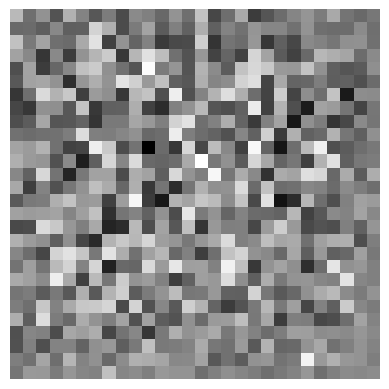

In [10]:
# create a generator
generator = Generator(image_size=(28,28), n_channels=num_channels, n_latent=d_z, n_filters=(256,128,64)).to(device)

# initalize parameters of generator
generator.apply(weights_init)

# Sample noise as generator input
z = torch.randn(1, d_z, device=device)
        
# generate and plot the image
generated_image = generator(z)
# reshape to [1,C,W,H] then permute to [1,W,H,C] so channel dimension is at the end (required order for displaying images using imshow). 
generated_image_for_viz = generated_image.reshape(1, num_channels, image_size[0], image_size[1]).permute(0,2,3,1)  
generated_image_for_viz = generated_image_for_viz.detach().cpu()
plt.figure(dpi=100)
plt.imshow(generated_image_for_viz[0], cmap='gray')
plt.axis('off')
plt.show()

### The discriminator

Next, we create the discriminator network. The discriminator takes an image and downsample it into a single real number between 0 and 1. The output being 0 means the discriminator classifies the image as fake, and 1 as real. We use `Conv2D` to downsample the images. 

Again, for size validation,  we can use the **untrained** discriminator to check the image we just generated. Note that we do not use `sigmoid` as the activation function of the last layer, so the output does not necessarily range between 0 and 1. Using `sigmoid` is also correct, but it slows down convergence at the early stage of training (as we want to save some time in this course).

**Takeaway**: the discriminator transforms an image into a real number.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_size, n_channels=1, n_filters=(64,128)):
        """
        Create a discriminator, hardcoded with two Conv2D layers. 

        Args:
            input_size (tuple[int]): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            nc (int): Number of channels in the image, e.g. RGC is 3 and greyscale is 1. Defaults to 1.
            n_filters (tuple[int]): Number of filters in each layer. Defaults to (64,128).
        """
        super(Discriminator, self).__init__()
        
        k = 5           # kernel_size
        p = k // 2      # padding
        
        # The net will downscale the image size twice so the final image size before flattening will be:
        w_final = input_size[0] // 2**2
        h_final = input_size[1] // 2**2
        self.wh_final = w_final*h_final
        
        self.net = nn.Sequential(
            # input is an image (can be real/fake) of shape (b, nc, image_size[0], image_size[1])
            # input shape: (b, 1, 28, 28)
            # output shape: (b, 64, 14, 14)
            nn.Conv2d(n_channels, n_filters[0], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        
            # input shape: (b, 64, 14, 14)
            # output shape: (b, 128, 7, 7)
            nn.Conv2d(n_filters[0], n_filters[1], 
                      kernel_size=k, stride=2, padding=p, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # input shape: (b, 128, 7, 7)
            # output shape: (b, 128*7*7)
            nn.Flatten(start_dim=1),
            
            # input shape: (b, 128*7*7)
            # output shape: (b, 1)
            nn.Linear(n_filters[1]*self.wh_final, 1)
            # nn.Sigmoid()        # (not used for convergence reasons for this tutorial)
        )
        
    def forward(self, input):
        return self.net(input)

Use torchsummary to see how the input will change shape when passed through the different layers of the network. 

In [12]:
summary = summary(Discriminator(), (num_channels, image_size[0], image_size[1]), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 14, 14]          1,600
|    └─LeakyReLU: 2-2                    [-1, 64, 14, 14]          --
|    └─Dropout: 2-3                      [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 128, 7, 7]           204,800
|    └─LeakyReLU: 2-5                    [-1, 128, 7, 7]           --
|    └─Dropout: 2-6                      [-1, 128, 7, 7]           --
|    └─Flatten: 2-7                      [-1, 6272]                --
|    └─Linear: 2-8                       [-1, 1]                   6,273
Total params: 212,673
Trainable params: 212,673
Non-trainable params: 0
Total mult-adds (M): 10.57
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.81
Estimated Total Size (MB): 0.96


In [13]:
# create a discriminator
discriminator = Discriminator(n_channels=num_channels, n_filters=(64,128,256)).to(device)
discriminator.apply(weights_init)
# check an image being passed in
decision = discriminator(generated_image)
print(f"Discirminator decision: Probability the image is fake = {decision.item():.2f}")

Discirminator decision: Probability the image is fake = -0.01


---

# Training Loop

Now we can train the model. GANs converge slowly in general. Here we only do 5 epochs, after which the generated images start to resemble handwritten digits. Do more epochs to reach a better quality.

The training loop begins by using the discriminator is to classify real images (drawn from the training set) and fakes images (produced by the generator receiving a random seed as input). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

### Loss functions

This discriminator's loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
# Training Loop
# create fresh generator and discriminator and initalize weights
generator = Generator(image_size, n_channels=num_channels, n_latent=d_z, n_filters=(256,128,64)).to(device)
discriminator = Discriminator(image_size, n_channels=num_channels, n_filters=(64,128)).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize the loss function
criterion = nn.BCEWithLogitsLoss()

# Setup Adam optimizers for both G and D
optimizer_D = Adam(discriminator.parameters(), lr=lr)
optimizer_G = Adam(generator.parameters(), lr=lr)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(viz_batch_size, d_z, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        # we don't need labels for training a simple GAN, so we ignore them
        real_imgs, _ = data
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.shape[0]
        
        # Adversarial ground truths, real=1 and fake=0
        real_labels = torch.full((bsz,), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((bsz,), fake_label, dtype=torch.float, device=device)

        ###############################################################################################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###############################################################################################################################
        optimizer_D.zero_grad()
        # disciminate real images
        out_real = discriminator(real_imgs).view(-1)
        real_loss = criterion(out_real, real_labels)
        
        # discriminate fake iamges generated by generator 
        z = torch.randn(bsz, d_z, 1, 1, device=device)
        fake_imgs = generator(z)
        # we only want to train the discriminator at this point, so we have to stop gradient flow to the generator via .detach()
        out_fake = discriminator(fake_imgs.detach()).view(-1)
        fake_loss = criterion(out_fake, fake_labels)
        
        # total loss
        d_loss = (real_loss + fake_loss) 
        d_loss.backward()
        optimizer_D.step()

        ###############################################################################################################################
        # (2) Update G network: maximize log(D(G(z)))
        ###############################################################################################################################
        optimizer_G.zero_grad()
        # this time we want to train the generator, so we keep the gradients (unlike above where we used .detach())
        out_fake = discriminator(fake_imgs).view(-1)
        # a good generator will be able to trick the discriminator into thinking the image is real
        g_loss = criterion(out_fake, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        ###############################################################################################################################        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/235]	Loss_D: 1.3807	Loss_G: 0.6903
[0/5][50/235]	Loss_D: 0.4466	Loss_G: 1.2388
[0/5][100/235]	Loss_D: 0.7297	Loss_G: 0.7441
[0/5][150/235]	Loss_D: 1.0643	Loss_G: 0.4635
[0/5][200/235]	Loss_D: 0.9832	Loss_G: 0.5274
[1/5][0/235]	Loss_D: 0.9657	Loss_G: 0.5729
[1/5][50/235]	Loss_D: 1.0330	Loss_G: 0.5302
[1/5][100/235]	Loss_D: 1.1037	Loss_G: 0.5438
[1/5][150/235]	Loss_D: 1.0771	Loss_G: 0.5727
[1/5][200/235]	Loss_D: 0.9616	Loss_G: 0.6329
[2/5][0/235]	Loss_D: 1.1450	Loss_G: 0.5401
[2/5][50/235]	Loss_D: 0.9720	Loss_G: 0.7214
[2/5][100/235]	Loss_D: 1.2920	Loss_G: 0.4973
[2/5][150/235]	Loss_D: 1.1234	Loss_G: 0.6429
[2/5][200/235]	Loss_D: 1.1181	Loss_G: 0.6937
[3/5][0/235]	Loss_D: 1.3004	Loss_G: 0.6236
[3/5][50/235]	Loss_D: 1.0578	Loss_G: 0.7923
[3/5][100/235]	Loss_D: 1.2616	Loss_G: 0.6338
[3/5][150/235]	Loss_D: 1.0536	Loss_G: 0.8365
[3/5][200/235]	Loss_D: 1.1430	Loss_G: 0.7632
[4/5][0/235]	Loss_D: 1.1753	Loss_G: 0.7619
[4/5][50/235]	Loss_D: 1.2443	Loss_G: 0.7072

### Plot the training losses of the generator and discriminator

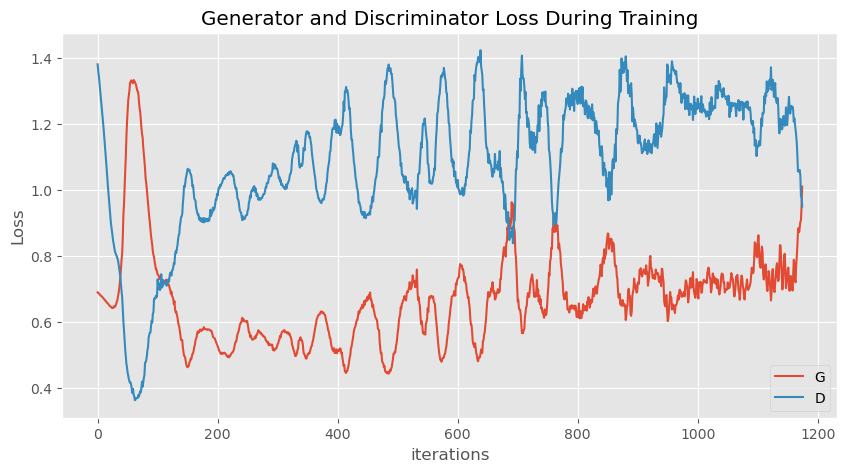

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Finally, we can use the trained generator to generate images from some random noise:

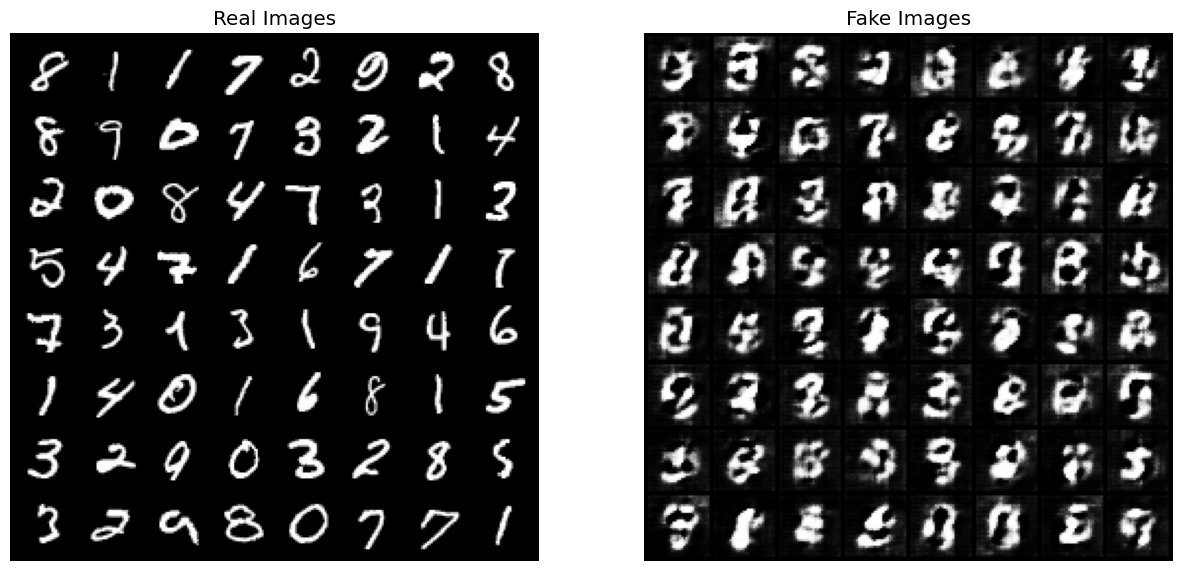

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

---

## Exercises

### Asynchronous Training
Improve the training loop to allow for asynchronous training. 
Modify the train loop to include 2 if statements, which determine whether the generator and the discriminator should be updated during an batch iteration (i.e., when you are looping through the `train_dataloader`). 

Use batch index `i` to determine the two booleans for each if statement; for example, 
- update the discriminator for every `i` and
- update the generator when `i%2=0`. 

### Wasserstein loss
Implement the wasserstein loss:

* Discriminator loss: $D(x)-D(G(z))$

* Generator loss: $D(G(z))$


### c-GAN
We can extend our GAN into a conditional GAN or c-GAN so that we can specify the label to be generated. We must send the labels (0~9) to both the generator and discriminator.
To see example code on how to implement a c-GAN see https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py.